# 01 - Exploratory Data Analysis

**BuzzwordLearner: Predicting Career Domain and Seniority from LinkedIn Profiles**

This notebook explores the LinkedIn CV dataset to understand:
1. Dataset structure and size
2. Label distributions (department/domain and seniority)
3. Text characteristics (length, language, patterns)
4. Career history patterns
5. Data quality issues

Test Test Test

## Setup

In [184]:
import sys
sys.path.insert(0, '..')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path

# Set Seaborn style
sns.set_theme(style='darkgrid')
sns.set_context('notebook')

# Data directory
DATA_DIR = Path('../data')

print("Setup complete!")

Setup complete!


## 1. Load the Data

In [225]:
# Load annotated LinkedIn CVs
with open(DATA_DIR / 'linkedin-cvs-annotated.json', 'r', encoding='utf-8') as f:
    cvs_annotated = json.load(f)

# Load non-annotated LinkedIn CVs
with open(DATA_DIR / 'linkedin-cvs-not-annotated.json', 'r', encoding='utf-8') as f:
    cvs_not_annotated = json.load(f)

# Load label dictionaries
department_labels = pd.read_csv(DATA_DIR / 'department-v2.csv')
seniority_labels = pd.read_csv(DATA_DIR / 'seniority-v2.csv')

# Display dataset overview as table
dataset_info = pd.DataFrame({
    'Dataset': ['Annotated CVs', 'Non-annotated CVs', 'Department label examples', 'Seniority label examples'],
    'Count': [len(cvs_annotated), len(cvs_not_annotated), len(department_labels), len(seniority_labels)]
})
display(dataset_info)

,Dataset,Count
0,Annotated CVs,609
1,Non-annotated CVs,390
2,Department label examples,10145
3,Seniority label examples,9428


## 2. Understanding the Data Structure

Each CV is a list of positions. Let's examine the structure:

In [186]:
# Look at the first CV
print("First CV (person with multiple positions):")
print(json.dumps(cvs_annotated[0], indent=2))

First CV (person with multiple positions):
[
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
    "position": "Prokurist",
    "startDate": "2019-08",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Other",
    "seniority": "Management"
  },
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
    "position": "CFO",
    "startDate": "2019-07",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Other",
    "seniority": "Management"
  },
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
    "position": "Betriebswirtin",
    "startDate": "2019-07",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Other",
    "seniority": "Professional"
  },
  {
    "organization": "Depot4Design GmbH",
    "linkedin": "https://www.linkedin.com/company/depot4design-gmbh",
  

In [187]:
# Look at another example CV
print(json.dumps(cvs_annotated[1], indent=2))

[
  {
    "organization": "Computer Solutions",
    "linkedin": "https://www.linkedin.com/company/computer-solutions",
    "position": "Solutions Architect",
    "startDate": "2024-03",
    "endDate": null,
    "status": "ACTIVE",
    "department": "Information Technology",
    "seniority": "Professional"
  },
  {
    "organization": "Computer Solutions",
    "linkedin": "https://www.linkedin.com/company/computer-solutions",
    "position": "Senior Network Engineer",
    "startDate": "2019-07",
    "endDate": "2024-03",
    "status": "INACTIVE",
    "department": "Information Technology",
    "seniority": "Senior"
  },
  {
    "organization": "Texas A&M University-Corpus Christi",
    "linkedin": "",
    "position": "Manager of Network Services",
    "startDate": "2017-02",
    "endDate": "2019-07",
    "status": "INACTIVE",
    "department": "Information Technology",
    "seniority": "Professional"
  },
  {
    "organization": "Texas A&M University-Corpus Christi",
    "linkedin": "",

In [188]:
# Extract all fields from positions
sample_position = cvs_annotated[0][0]
print("Position fields:")
for key, value in sample_position.items():
    print(f"  - {key}: {type(value).__name__} (example: {repr(value)[:50]}...)")

Position fields:
  - organization: str (example: 'Depot4Design GmbH'...)
  - linkedin: str (example: 'https://www.linkedin.com/company/depot4design-gmb...)
  - position: str (example: 'Prokurist'...)
  - startDate: str (example: '2019-08'...)
  - endDate: NoneType (example: None...)
  - status: str (example: 'ACTIVE'...)
  - department: str (example: 'Other'...)
  - seniority: str (example: 'Management'...)


### Key Observations:
- Each CV is a **list of positions** (current and past jobs)
- Position fields: `organization`, `linkedin`, `position`, `startDate`, `endDate`, `status`, `department`, `seniority`
- status: `ACTIVE` (current job), `INACTIVE` (past job), `UNKNOWN`
- Target variables: `department` and `seniority` (only in annotated data)
- Input for prediction: The `position` field (job title)

## 3. Flatten Data for Analysis

In [189]:
def flatten_cvs(cvs, cv_id_start=0):
    """Flatten list of CVs into a DataFrame of positions."""
    records = []
    for cv_id, cv in enumerate(cvs, start=cv_id_start):
        for pos_idx, position in enumerate(cv):
            record = {
                'cv_id': cv_id,
                'position_idx': pos_idx,
                **position
            }
            records.append(record)
    return pd.DataFrame(records)

# Flatten annotated data
df_annotated = flatten_cvs(cvs_annotated)
print(f"Total positions in annotated data: {len(df_annotated)}")
print(f"Total CVs (unique cv_id): {df_annotated['cv_id'].nunique()}")
df_annotated.head(10)

Total positions in annotated data: 2638
Total CVs (unique cv_id): 609


,cv_id,position_idx,organization,linkedin,position,startDate,endDate,status,department,seniority
0,0,0,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokurist,2019-08,None,ACTIVE,Other,Management
1,0,1,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,None,ACTIVE,Other,Management
2,0,2,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Betriebswirtin,2019-07,None,ACTIVE,Other,Professional
3,0,3,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,Prokuristin,2019-07,None,ACTIVE,Other,Management
4,0,4,Depot4Design GmbH,https://www.linkedin.com/company/depot4design-...,CFO,2019-07,None,ACTIVE,Other,Management
5,0,5,Nagel Car Group,,Buchhalterin,2000-05,2019-06,INACTIVE,Other,Professional
6,1,0,Computer Solutions,https://www.linkedin.com/company/computer-solu...,Solutions Architect,2024-03,None,ACTIVE,Information Technology,Professional
7,1,1,Computer Solutions,https://www.linkedin.com/company/computer-solu...,Senior Network Engineer,2019-07,2024-03,INACTIVE,Information Technology,Senior
8,1,2,Texas A&M University-Corpus Christi,,Manager of Network Services,2017-02,2019-07,INACTIVE,Information Technology,Professional
9,1,3,Texas A&M University-Corpus Christi,,Infrastructure Administrator II,2015-06,2017-02,INACTIVE,Information Technology,Professional


In [190]:
# Basic info
df_annotated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2638 entries, 0 to 2637
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cv_id         2638 non-null   int64 
 1   position_idx  2638 non-null   int64 
 2   organization  2638 non-null   object
 3   linkedin      2638 non-null   object
 4   position      2638 non-null   object
 5   startDate     2520 non-null   object
 6   endDate       1897 non-null   object
 7   status        2638 non-null   object
 8   department    2638 non-null   object
 9   seniority     2638 non-null   object
dtypes: int64(2), object(8)
memory usage: 206.2+ KB


In [191]:
df_annotated.shape

(2638, 10)

In [192]:
df_annotated.describe().round(2)
display(df_annotated.describe(include='object'))

,organization,linkedin,position,startDate,endDate,status,department,seniority
count,2638,2638,2638,2520,1897,2638,2638,2638
unique,1958,1083,2066,494,420,3,11,6
top,Siemens,,Geschäftsführer,2018-01,2023-12,INACTIVE,Other,Professional
freq,13,976,41,24,19,1897,1252,1219


### Check for Missing Values:

In [193]:
# Display missing values, their percentage, and unique value counts for each column
combined_info = pd.DataFrame({
    "Missing Values": df_annotated.isnull().sum(),
    "Missing (%)": (df_annotated.isnull().sum() / len(df_annotated) * 100).round(2),
    "Unique Values": df_annotated.nunique()
})

display(combined_info)

,Missing Values,Missing (%),Unique Values
cv_id,0,0.00,609
position_idx,0,0.00,37
organization,0,0.00,1958
linkedin,0,0.00,1083
position,0,0.00,2066
startDate,118,4.47,494
endDate,741,28.09,420
status,0,0.00,3
department,0,0.00,11
seniority,0,0.00,6


- **No missing values** in critical fields
- `startDate` and `endDate` have some missing values - positions without clear date information
- All positions have the essential information needed for classification

### Check for Duplicates:

In [194]:
# Check for duplicate rows in the dataset
duplicate_info = pd.DataFrame({
    "Metric": ["Duplicate Rows"],
    "Count": [df_annotated.duplicated().sum()]
})
display(duplicate_info)

,Metric,Count
0,Duplicate Rows,0


## 4. Filter to ACTIVE Positions (Our Target)

According to the project description, we need to predict characteristics of the **current job** (status = ACTIVE).

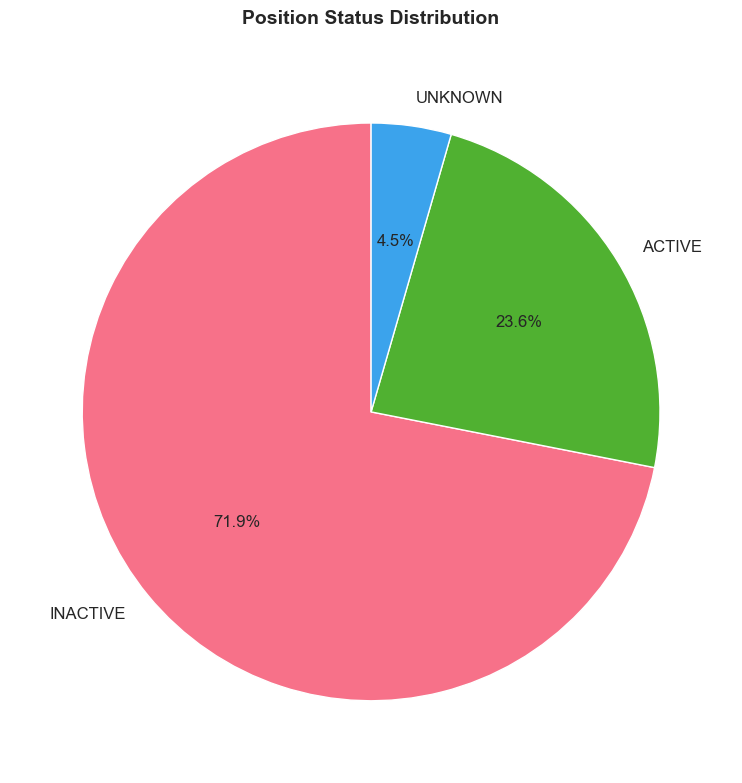

In [195]:
# Visualize status distribution as pie chart
status_counts = df_annotated['status'].value_counts()
colors = sns.color_palette('husl', n_colors=len(status_counts))

plt.figure(figsize=(8, 8))
plt.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=colors, textprops={'fontsize': 12})
plt.title('Position Status Distribution', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../reports/figures/status_distribution_pie.png', dpi=150)
plt.show()

In [196]:
# Filter to active positions only
df_active = df_annotated[df_annotated['status'] == 'ACTIVE'].copy()
print(f"Active positions: {len(df_active)}")
print(f"Unique CVs with active positions: {df_active['cv_id'].nunique()}")

Active positions: 623
Unique CVs with active positions: 478


In [218]:
# Some people have multiple active positions!
active_per_cv = df_active.groupby('cv_id').size()
active_counts = active_per_cv.value_counts().sort_index()

active_table = pd.DataFrame({
    'Active Positions': active_counts.index,
    'Number of CVs': active_counts.values,
    'Percentage (%)': (active_counts / active_counts.sum() * 100).round(2)
})

print("Active positions per CV:")
display(active_table)

Active positions per CV:


,Active Positions,Number of CVs,Percentage (%)
1,1,380,79.50
2,2,78,16.32
3,3,10,2.09
4,4,3,0.63
5,5,4,0.84
7,7,1,0.21
8,8,1,0.21
10,10,1,0.21


In [197]:
# Check for most common values in active positions
print("Most Common Values in Active Positions:\n")

# Most common organizations
print("=== Top 10 Organizations (Active Positions) ===")
org_counts = df_active['organization'].value_counts().head(10)
org_table = pd.DataFrame({
    'Organization': org_counts.index,
    'Count': org_counts.values,
    'Percentage (%)': (org_counts / len(df_active) * 100).round(2)
})
display(org_table)

# Most common position titles
print("\n=== Top 10 Position Titles (Active Positions) ===")
position_counts = df_active['position'].value_counts().head(10)
position_table = pd.DataFrame({
    'Position Title': position_counts.index,
    'Count': position_counts.values,
    'Percentage (%)': (position_counts / len(df_active) * 100).round(2)
})
display(position_table)

Most Common Values in Active Positions:

=== Top 10 Organizations (Active Positions) ===


,Organization,Count,Percentage (%)
organization,,,
Depot4Design GmbH,Depot4Design GmbH,5,0.80
Selbstständig,Selbstständig,5,0.80
OpenExO,OpenExO,5,0.80
Frankfurt School of Finance & Management,Frankfurt School of Finance & Management,4,0.64
GENUSSMOMENTE für digitales Zusammensein,GENUSSMOMENTE für digitales Zusammensein,3,0.48
KAISERSCHOTE Feinkost Catering GmbH,KAISERSCHOTE Feinkost Catering GmbH,3,0.48
ALIUD PHARMA GmbH,ALIUD PHARMA GmbH,3,0.48
Freelance,Freelance,3,0.48
Yatego GmbH,Yatego GmbH,2,0.32



=== Top 10 Position Titles (Active Positions) ===


,Position Title,Count,Percentage (%)
position,,,
Geschäftsführer,Geschäftsführer,19,3.05
Managing Director,Managing Director,12,1.93
CEO,CEO,11,1.77
Geschäftsführender Gesellschafter,Geschäftsführender Gesellschafter,9,1.44
Unternehmensinhaber,Unternehmensinhaber,6,0.96
Owner,Owner,6,0.96
Partner,Partner,6,0.96
Set Lighting,Set Lighting,5,0.80
Member,Member,5,0.80


## 5. Department (Domain) Analysis

In [219]:
# Department distribution in active positions
dept_counts = df_active['department'].value_counts()
dept_percentages = (dept_counts / dept_counts.sum() * 100).round(2)

dept_table = pd.DataFrame({
    'Department': dept_counts.index,
    'Count': dept_counts.values,
    'Percentage (%)': dept_percentages.values
})

print(f"Unique departments: {len(dept_counts)}\n")
print("Department Distribution:")
display(dept_table)

Unique departments: 11

Department Distribution:


,Department,Count,Percentage (%)
0,Other,344,55.22
1,Information Technology,62,9.95
2,Sales,46,7.38
3,Consulting,39,6.26
4,Project Management,39,6.26
5,Marketing,22,3.53
6,Business Development,20,3.21
7,Human Resources,16,2.57
8,Purchasing,15,2.41
9,Administrative,14,2.25


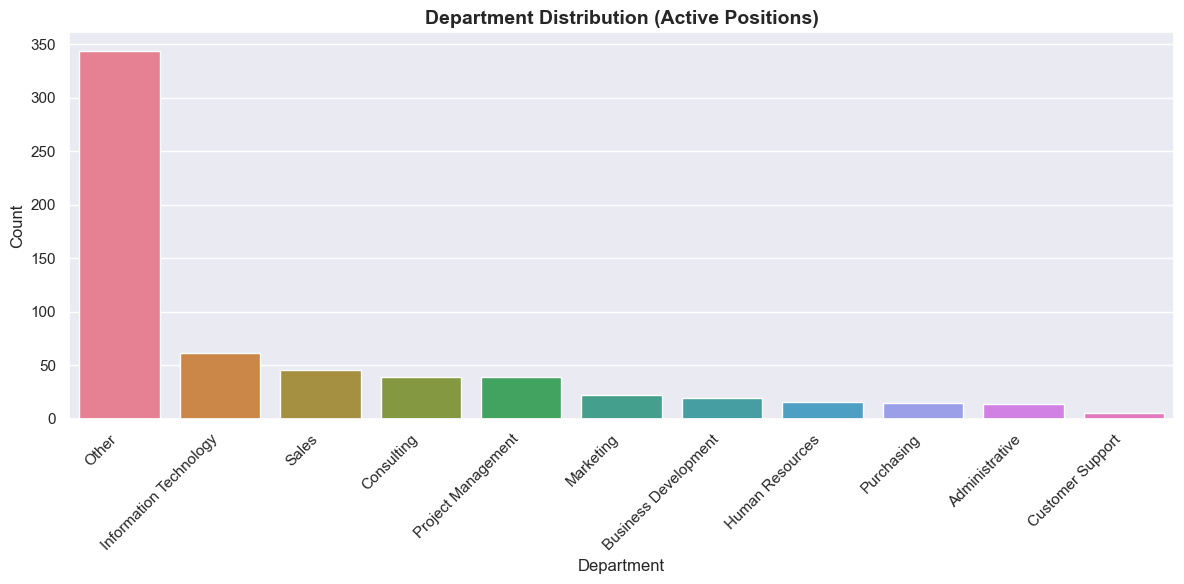

In [200]:
# Visualize department distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=dept_counts.index, y=dept_counts.values, hue=dept_counts.index, legend=False)
plt.title('Department Distribution (Active Positions)', fontsize=14, fontweight='bold')
plt.xlabel('Department')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/department_distribution.png', dpi=150)
plt.show()

### Department Observations:
- **"Other"** is the most common category - this is a catch-all for unclassified positions
- **Class imbalance** is significant - some departments have very few samples

## 6. Seniority Analysis

In [226]:
# Seniority distribution
seniority_counts = df_active['seniority'].value_counts()

seniority_dist_table = pd.DataFrame({
    'Seniority Level': seniority_counts.index,
    'Count': seniority_counts.values
})

print(f"Unique seniority levels: {len(seniority_counts)}\n")
print("Seniority Distribution:")
display(seniority_dist_table)

Unique seniority levels: 6

Seniority Distribution:


,Seniority Level,Count
0,Professional,216
1,Management,192
2,Lead,125
3,Senior,44
4,Director,34
5,Junior,12


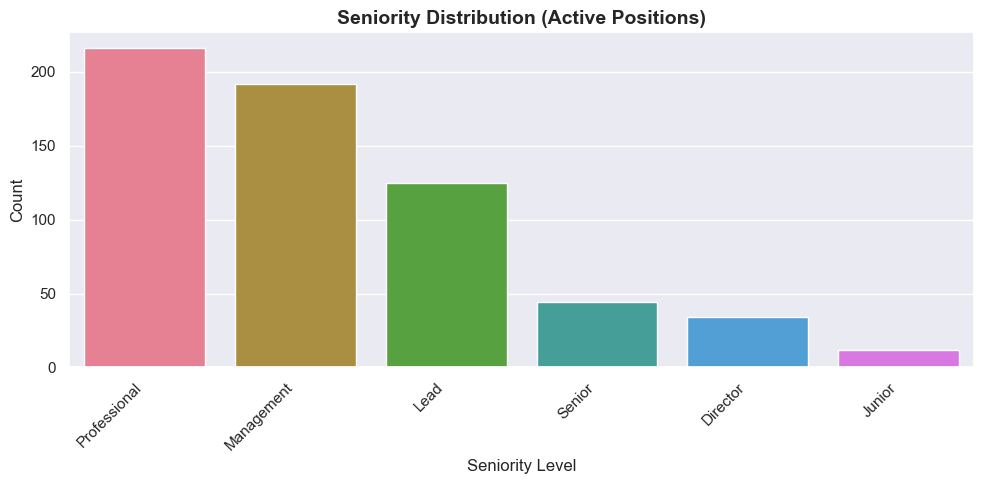

In [203]:
# Visualize seniority distribution
plt.figure(figsize=(10, 5))

# Sort by count (descending)
seniority_ordered = seniority_counts.sort_values(ascending=False)

sns.barplot(x=seniority_ordered.index, y=seniority_ordered.values, hue=seniority_ordered.index, palette='husl', legend=False)
plt.title('Seniority Distribution (Active Positions)', fontsize=14, fontweight='bold')
plt.xlabel('Seniority Level')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/figures/seniority_distribution.png', dpi=150)
plt.show()

In [224]:
# Seniority proportions
seniority_props = (seniority_counts / seniority_counts.sum() * 100).round(1)

seniority_table = pd.DataFrame({
    'Seniority Level': seniority_props.index,
    'Percentage (%)': seniority_props.values
})

print("Seniority Proportions (%):")
display(seniority_table)

Seniority Proportions (%):


,Seniority Level,Percentage (%)
0,Professional,34.7
1,Management,30.8
2,Lead,20.1
3,Senior,7.1
4,Director,5.5
5,Junior,1.9


### Seniority Observations:
- **Professional** (34.7%) and **Management** (30.8%) dominate the dataset
- **Lead** positions represent 20.1% - well-represented
- **Senior** (7.1%), **Director** (5.5%), and **Junior** (1.9%) are less common
- More balanced distribution than departments
- All seniority levels have at least some representation

## 7. Position Title (Text) Analysis

In [223]:
# Text length analysis
df_active['title_length'] = df_active['position'].str.len()
df_active['title_word_count'] = df_active['position'].str.split().str.len()

print("Position Title Statistics:")
stats_table = df_active[['title_length', 'title_word_count']].describe().T
stats_table = stats_table.round(2)
display(stats_table)

Position Title Statistics:


,count,mean,std,min,25%,50%,75%,max
title_length,623.0,25.03,16.11,3.0,15.0,21.0,33.0,99.0
title_word_count,623.0,3.02,2.22,1.0,1.0,2.0,4.0,15.0


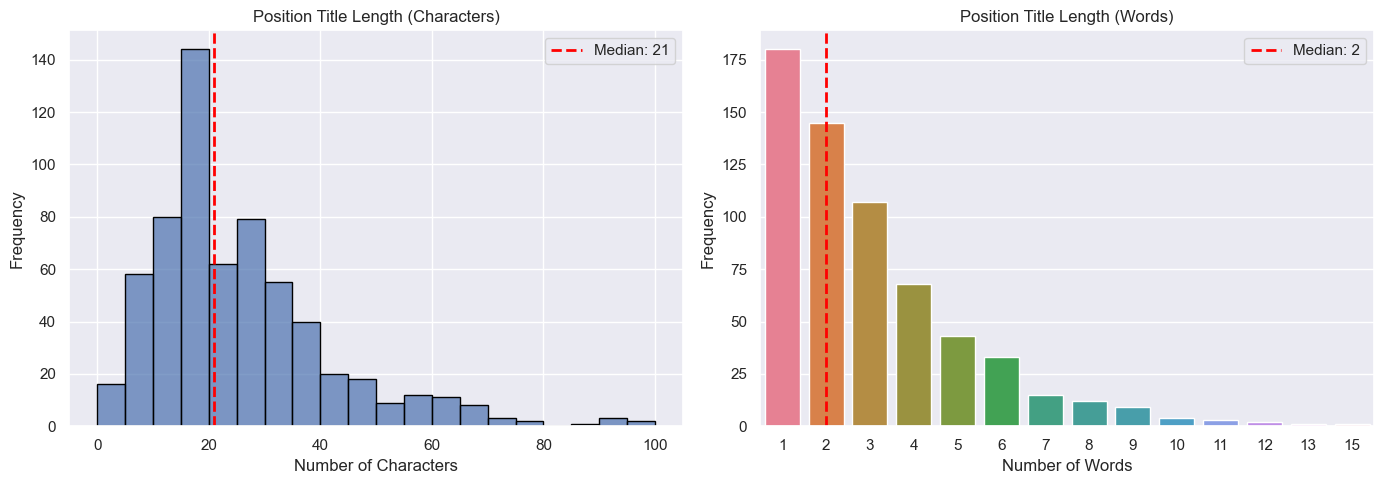

In [206]:
# Visualize title length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character length - use bins aligned with integer values
bins = range(0, int(df_active['title_length'].max()) + 5, 5)
sns.histplot(df_active['title_length'], bins=bins, kde=False, ax=axes[0], edgecolor='black', alpha=0.7)
axes[0].set_title('Position Title Length (Characters)', fontsize=12)
axes[0].set_xlabel('Number of Characters')
axes[0].set_ylabel('Frequency')
median_chars = df_active['title_length'].median()
axes[0].axvline(median_chars, color='red', linestyle='--', linewidth=2, label=f"Median: {median_chars:.0f}")
axes[0].legend()

# Word count - use countplot for discrete integer values
word_order = sorted(df_active['title_word_count'].dropna().unique())
sns.countplot(x=df_active['title_word_count'], ax=axes[1], hue=df_active['title_word_count'], palette='husl', order=word_order, legend=False)
axes[1].set_title('Position Title Length (Words)', fontsize=12)
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
# For countplot, axvline uses bar index (0, 1, 2...), not the actual x-value
median_words = df_active['title_word_count'].median()
median_idx = word_order.index(median_words) if median_words in word_order else None
if median_idx is not None:
    axes[1].axvline(median_idx, color='red', linestyle='--', linewidth=2, label=f"Median: {median_words:.0f}")
    axes[1].legend()

plt.tight_layout()
plt.savefig('../reports/figures/title_length_distribution.png', dpi=150)
plt.show()

In [220]:
# Sample position titles by department
sample_data = []
for dept in df_active['department'].unique()[:8]:  # First 8 departments
    samples = df_active[df_active['department'] == dept]['position'].head(5).tolist()
    for sample in samples:
        sample_data.append({
            'Department': dept,
            'Position Title': sample
        })

sample_table = pd.DataFrame(sample_data)
print("Sample Position Titles by Department:")
display(sample_table)

Sample Position Titles by Department:


,Department,Position Title
0,Other,Prokurist
1,Other,CFO
2,Other,Betriebswirtin
3,Other,Prokuristin
4,Other,CFO
5,Information Technology,Solutions Architect
6,Information Technology,Principal RF Design Engineer
7,Information Technology,IT Systems and Network Engineer
8,Information Technology,IT-Teamleiter
9,Information Technology,Senior IT-Sicherheitsbeauftragter


## 8. Language Detection (Multilingual Data)

In [221]:
# Simple language detection based on common words
def detect_language_simple(text):
    """Simple heuristic-based language detection."""
    text_lower = text.lower()
    
    # English indicators
    english_words = ['manager', 'senior', 'lead', 'engineer', 'developer', 'analyst', 'consultant', 'specialist', 
                    'coordinator', 'director', 'assistant', 'executive', 'officer', 'supervisor', 'administrator', 
                    'technician', 'designer', 'architect', 'sales', 'marketing', 'project', 'business']
    # German indicators
    german_words = ['und', 'der', 'die', 'für', 'bei', 'leiter', 'berater', 'mitarbeiter', 'geschäftsführer', 'vertrieb',
                    'kaufmann', 'ingenieur', 'entwickler', 'sachbearbeiter', 'direktor', 'koordinator', 'stellvertreter',
                    'abteilungsleiter', 'projektleiter', 'fachkraft', 'assistent', 'referent', 'teamleiter', 'verwaltungsangestellter', 'bauverwaltung']
    # French indicators
    french_words = ['de', 'du', 'la', 'le', 'responsable', 'directeur', 'chargé', 'chef',
                    'ingénieur', 'coordinateur', 'adjoint', 'technicien', 'gestionnaire', 'administrateur',
                    'superviseur', 'cadre', 'attaché', 'contrôleur', 'conseiller', 'analyste']
    # Spanish indicators
    spanish_words = ['de', 'del', 'director', 'gerente', 'jefe',
                    'coordinador', 'ingeniero', 'técnico', 'administrador', 'ejecutivo', 'asistente',
                    'supervisor', 'encargado', 'responsable', 'especialista', 'analista', 'consultor']
    # Turkish indicators
    turkish_words = ['ve', 'müdür', 'uzman', 'sorumlu', 'başkan', 'yönetici', 'danışman', 'müdürü',
                    'koordinatör', 'mühendis', 'teknisyen', 'asistan', 'yardımcısı', 'genel', 'bölüm',
                    'şef', 'direktör', 'proje', 'uzmanı', 'başkanı']
    
    english_score = sum(1 for w in english_words if w in text_lower)
    german_score = sum(1 for w in german_words if w in text_lower)
    french_score = sum(1 for w in french_words if w in text_lower)
    spanish_score = sum(1 for w in spanish_words if w in text_lower)
    turkish_score = sum(1 for w in turkish_words if w in text_lower)
    
    # Return language with highest score
    max_score = max(english_score, german_score, french_score, spanish_score, turkish_score)
    if max_score == 0:
        return 'Other'
    elif english_score == max_score:
        return 'English'
    elif german_score == max_score:
        return 'German'
    elif french_score == max_score:
        return 'French'
    elif spanish_score == max_score:
        return 'Spanish'
    else:
        return 'Turkish'

df_active['detected_language'] = df_active['position'].apply(detect_language_simple)

# Create language distribution table
lang_counts = df_active['detected_language'].value_counts()
lang_table = pd.DataFrame({
    'Language': lang_counts.index,
    'Count': lang_counts.values,
    'Percentage (%)': (lang_counts / lang_counts.sum() * 100).round(2)
})

print("Detected Languages:")
display(lang_table)

Detected Languages:


,Language,Count,Percentage (%)
detected_language,,,
English,English,238,38.20
Other,Other,172,27.61
German,German,134,21.51
French,French,66,10.59
Spanish,Spanish,7,1.12
Turkish,Turkish,6,0.96


In [222]:
# Sample titles by detected language
sample_lang_data = []
for lang in df_active['detected_language'].unique():
    samples = df_active[df_active['detected_language'] == lang]['position'].sample(min(5, len(df_active[df_active['detected_language'] == lang]))).tolist()
    for sample in samples:
        sample_lang_data.append({
            'Language': lang,
            'Position Title': sample
        })

sample_lang_table = pd.DataFrame(sample_lang_data)
print("Sample Position Titles by Language:")
display(sample_lang_table)

Sample Position Titles by Language:


,Language,Position Title
0,Other,CFO
1,Other,In non compete phase
2,Other,Head of Content & Workflows
3,Other,Rechtsanwalt
4,Other,Head of ICT
5,English,Strategic Engagement Manager
6,English,"Executive Director, Marketing Strategy Director"
7,English,Accounting Manager
8,English,Senior Treasury Manager
9,English,Public Health Consultant


### Language Observations:
- The dataset is **multilingual** (English, German, French, Spanish, etc.)
- This is important for model design:
  - Rule-based matching needs multilingual patterns
  - Embeddings should use multilingual models

## 9. Label Dictionary Analysis

In [210]:
# Analyze department label dictionary
print("Department Label Dictionary:")
print(f"  Total examples: {len(department_labels)}")
print(f"  Unique labels: {department_labels['label'].nunique()}")
print("\n  Labels and counts:")
print(department_labels['label'].value_counts())

Department Label Dictionary:
  Total examples: 10145
  Unique labels: 11

  Labels and counts:
label
Marketing                 4295
Sales                     3328
Information Technology    1305
Business Development       620
Project Management         201
Consulting                 167
Administrative              83
Other                       42
Purchasing                  40
Customer Support            33
Human Resources             31
Name: count, dtype: int64


In [211]:
# Analyze seniority label dictionary
print("Seniority Label Dictionary:")
print(f"Total examples: {len(seniority_labels)}")
print(f"Unique labels: {seniority_labels['label'].nunique()}")
print("\nLabels and counts:")
print(seniority_labels['label'].value_counts())

Seniority Label Dictionary:
Total examples: 9428
Unique labels: 5

Labels and counts:
label
Senior        3733
Lead          3546
Director       984
Management     756
Junior         409
Name: count, dtype: int64


In [212]:
# Sample text -> label mappings
print("Sample Department Mappings:")
department_labels.sample(10)

Sample Department Mappings:


,text,label
3676,Executive Director Business Development,Business Development
5254,Geschäftsbereichleiter Projektgeschäft,Project Management
2544,Vertrieb / Marketing,Marketing
7594,Responsable communications / logistique /Assis...,Marketing
6210,Geschäftsleitung Marketing und Fundraising,Marketing
846,CRM IT Consultant,Information Technology
1311,EU Marketing and Communications,Marketing
2612,Supervisor International Fairs & Regional Trai...,Other
492,Administrateur des systèmes informatiques,Information Technology
8715,Marketing Manager Contruction,Marketing


In [213]:
print("Sample Seniority Mappings:")
seniority_labels.sample(10)

Sample Seniority Mappings:


,text,label
6829,Sr. Manager,Senior
5044,Leitung Fachbereich Kommunikation,Lead
2252,Junior Texterin,Junior
1244,Head of Sales & CIO,Management
1480,Director Business Development Aviation,Director
9094,Senior Sales Manager - Geschäftsstellenleiter,Senior
7437,Aftermarket Marketing Product Manager,Senior
1177,Geschäftsführer & CEO,Management
5511,Leiter Vertrieb Vollsortiment,Lead
2482,Head of Business Development & Innovation,Lead


## 10. Career History Patterns (Extensions)

Positions per CV:
count    609.000000
mean       4.331691
std        3.561259
min        1.000000
25%        1.000000
50%        4.000000
75%        6.000000
max       37.000000
dtype: float64


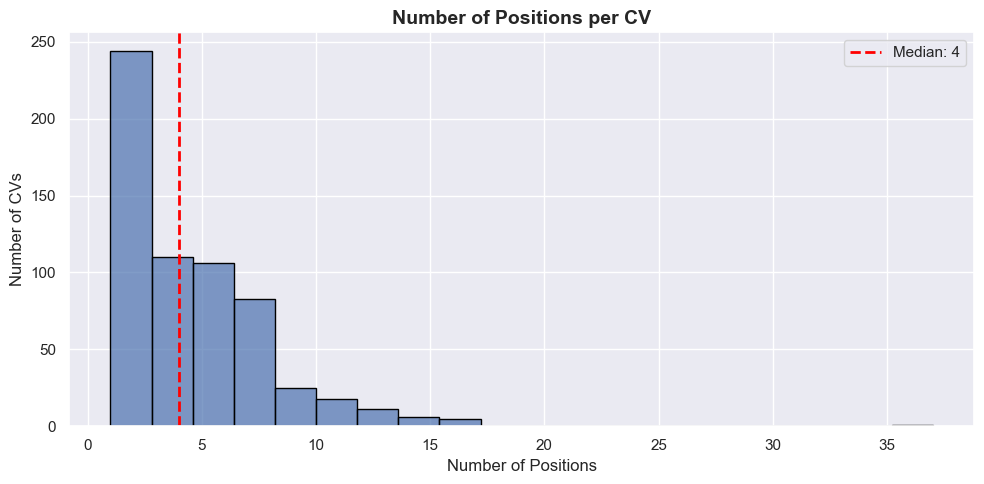

In [214]:
# Positions per CV
positions_per_cv = df_annotated.groupby('cv_id').size()

print("Positions per CV:")
print(positions_per_cv.describe())

plt.figure(figsize=(10, 5))
sns.histplot(positions_per_cv, bins=20, kde=False, edgecolor='black', alpha=0.7)
plt.title('Number of Positions per CV', fontsize=14, fontweight='bold')
plt.xlabel('Number of Positions')
plt.ylabel('Number of CVs')
plt.axvline(positions_per_cv.median(), color='red', linestyle='--', linewidth=2, label=f"Median: {positions_per_cv.median():.0f}")
plt.legend()
plt.tight_layout()
plt.savefig('../reports/figures/positions_per_cv.png', dpi=150)
plt.show()

In [215]:
# Department consistency within CVs
def get_cv_department_consistency(cv_id):
    cv_depts = df_annotated[df_annotated['cv_id'] == cv_id]['department'].unique()
    return len(cv_depts) == 1

cv_ids = df_annotated['cv_id'].unique()
consistent_count = sum(get_cv_department_consistency(cid) for cid in cv_ids)

print(f"CVs with consistent department across all positions: {consistent_count}/{len(cv_ids)} ({consistent_count/len(cv_ids):.1%})")

CVs with consistent department across all positions: 288/609 (47.3%)


## 11. Summary Statistics

In [216]:
# Create summary table
summary = {
    'Metric': [
        'Total CVs (annotated)',
        'Total CVs (unannotated)',
        'Total positions (annotated)',
        'Active positions (our training set)',
        'Avg positions per CV',
        'Unique departments',
        'Unique seniority levels',
        'Department label examples',
        'Seniority label examples',
        'Avg title length (chars)',
        'Avg title length (words)',
    ],
    'Value': [
        len(cvs_annotated),
        len(cvs_not_annotated),
        len(df_annotated),
        len(df_active),
        f"{positions_per_cv.mean():.1f}",
        df_active['department'].nunique(),
        df_active['seniority'].nunique(),
        len(department_labels),
        len(seniority_labels),
        f"{df_active['title_length'].mean():.1f}",
        f"{df_active['title_word_count'].mean():.1f}",
    ]
}

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

                             Metric Value
              Total CVs (annotated)   609
            Total CVs (unannotated)   390
        Total positions (annotated)  2638
Active positions (our training set)   623
               Avg positions per CV   4.3
                 Unique departments    11
            Unique seniority levels     6
          Department label examples 10145
           Seniority label examples  9428
           Avg title length (chars)  25.0
           Avg title length (words)   3.0


## 12. Key Findings & Implications for Modeling

### Data Characteristics:
1. **Multilingual data**: Position titles in English, German, French, Spanish → Need multilingual embeddings
2. **Class imbalance**: "Other" dominates departments → May need class weighting or resampling
3. **Short text**: Most titles are 2-5 words → Limited context for models
4. **Multiple active positions**: Some people have multiple current jobs → Handle carefully

### Modeling Implications:
1. **Rule-based**: Can leverage label dictionaries directly for exact/fuzzy matching
2. **Embedding-based**: Use multilingual models like `paraphrase-multilingual-MiniLM-L12-v2`
3. **Supervised**: Enough labeled examples for fine-tuning, but watch for class imbalance
4. **Extensions**: Career history can inform seniority (more positions = more experience)

### Next Steps:
1. Implement baseline rule-based classifier using exact matching
2. Test embedding similarity with label descriptions
3. Train TF-IDF + LogReg as supervised baseline
4. Compare approaches on held-out test set

In [217]:
# Save active positions for modeling
df_active.to_csv(DATA_DIR / 'active_positions_processed.csv', index=False)
print(f"Saved {len(df_active)} active positions to 'active_positions_processed.csv'")

Saved 623 active positions to 'active_positions_processed.csv'
